In [1]:
from fastai.data.all import *
from modules import FastSpeech
from data import TTSDataset, collate_fn
import librosa

In [2]:
torch.set_printoptions(precision=10, linewidth=140, sci_mode=False)

In [3]:
path_ds = Path("../data/LJSpeech-1.1/")
path_vocab = Path("../data/CMUDict/cmudict-0.7b.symbols.txt")

sample_rate = 22050
n_fft = 1024
hop_length = 256
n_bins = 80
ratio = 0.01
preload = True

n_hidden = 256
n_heads = 2
kernal_sz = 9
n_filters = 1024
n_blocks = 4
p_dropout = 0.1
kernal_sz_v = 3
n_filters_v = 256
p_dropout_v = 0.5
upsample_ratio = 1

bs = 128
epochs = 400
betas = (0.9, 0.98)
eps = 1e-9
max_lr = 1e-4
lr_mul = 1
warmup_steps = 4000
weight_decay = 0.0
grad_clip = 1.0
accum_grad = 1
log_interval = epochs // 100


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
ds = TTSDataset(path_ds, path_vocab, sample_rate, n_fft, 
                hop_length, n_bins, ratio, preload)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True,
                                 collate_fn=partial(collate_fn, pad_num=ds.pad_num))

In [6]:
mels, phones, durations = first(dl)
L(map(lambda x: x.shape, (mels, phones, durations)))

(#3) [torch.Size([128, 80, 814]),torch.Size([128, 131]),torch.Size([128, 131])]

In [7]:
model = FastSpeech(len(ds.vocab), n_hidden, n_bins, n_heads, kernal_sz, n_filters, n_blocks,
                   p_dropout, kernal_sz_v, n_filters_v, p_dropout_v, device).to(device)

In [8]:
n_params = sum(L(model.parameters()).map(lambda x: x.numel()))
print(f"Number of Parameters: {n_params}")

Number of Parameters: 40310097


In [9]:
mels_val, phones_val, durations_val = map(lambda x: x.to(device), first(dl))

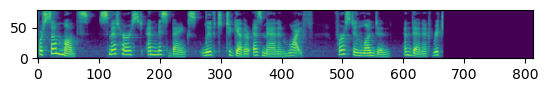

In [10]:
plt.imshow(librosa.power_to_db(mels_val[0].cpu()), origin='lower');

In [11]:
%time model(phones_val, durations_val, upsample_ratio);

CPU times: user 539 ms, sys: 261 ms, total: 800 ms
Wall time: 799 ms


In [12]:
from torch.optim import lr_scheduler
import torch.optim as optim
from training import TransformerScheduler, mae_loss

In [13]:
n_steps = int(epochs * len(dl) / accum_grad)
optimizer = optim.Adam(model.parameters(), max_lr, betas=betas, eps=eps, 
                         weight_decay=weight_decay) 
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr, total_steps=n_steps)

loss_fn_m = mae_loss
loss_fn_v = F.mse_loss
print(f"Number of steps: {n_steps}")

Number of steps: 800


In [14]:
from tqdm.auto import tqdm

In [18]:
model.load_state_dict(torch.load("models/model_100.pt"))

<All keys matched successfully>

In [16]:
model = model.to(device)

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0, Model Loss: 0.626488983631134, Duration Loss: 490.2844467163086


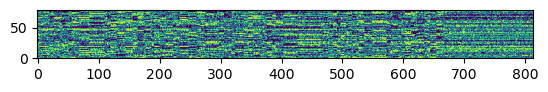

Epoch 4, Model Loss: 0.5487530827522278, Duration Loss: 511.15159606933594


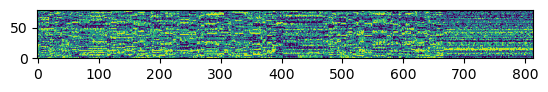

Epoch 8, Model Loss: 0.5345974117517471, Duration Loss: 556.0760803222656


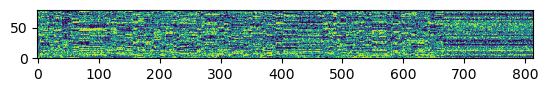

Epoch 12, Model Loss: 0.4735233187675476, Duration Loss: 508.92527770996094


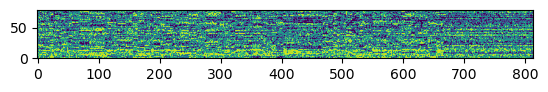

Epoch 16, Model Loss: 0.4131074696779251, Duration Loss: 581.0734252929688


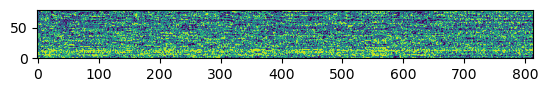

Epoch 20, Model Loss: 0.37841853499412537, Duration Loss: 580.9223327636719


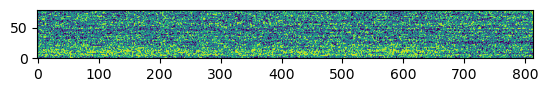

Epoch 24, Model Loss: 0.34534338116645813, Duration Loss: 678.8922119140625


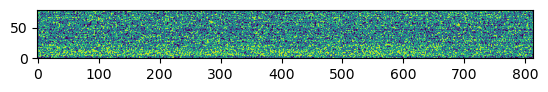

KeyboardInterrupt: 

In [17]:
model_num = 0
loss_tracking = []
loss_tracking_d = []
for i in tqdm(range(epochs)):
    running_loss = 0
    running_loss_d = 0
    for idx, data in enumerate(dl):
        mels, phones, durations = map(lambda x: x.to(device), data)
        optimizer.zero_grad()
        
        pred, pred_durations = model(phones, durations, upsample_ratio, True)
        
        loss_m = loss_fn_m(pred, mels) / accum_grad
        loss_d = loss_fn_v(pred_durations, durations.to(torch.float)) / accum_grad
            
        loss_m.backward()
        loss_d.backward()
        
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
        if (idx+1) % accum_grad == 0 or (idx+1) == len(dl):
            optimizer.step()
            scheduler.step()
        
        running_loss += loss_m.detach().item() / len(dl) * accum_grad
        running_loss_d += loss_d.detach().item() / len(dl) * accum_grad
    loss_tracking.append(running_loss)
    loss_tracking_d.append(running_loss_d)
    
    if i % log_interval == 0:
        print(f"Epoch {i}, Model Loss: {running_loss}, Duration Loss: {running_loss_d}")
        out = model(phones_val[None, 0], durations_val[None, 0], 
                    upsample_ratio).detach().cpu()[0]
        plt.imshow(librosa.power_to_db(out.numpy()), origin="lower");
        plt.show()
        model_path = f"models/model_save_{model_num}.pt"
        torch.save(model.state_dict(), model_path)
        model_num += 1

In [ ]:
plt.plot(loss_tracking)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show();

In [ ]:
plt.plot(loss_tracking_d)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Duration")
plt.show();

In [19]:
out = model(phones_val[None, 0], durations_val[None, 0], upsample_ratio).detach().cpu()

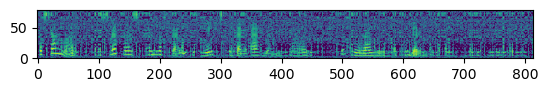

In [20]:
plt.imshow(librosa.power_to_db(out[0].numpy()), origin="lower");

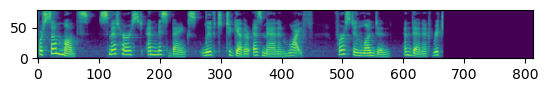

In [21]:
plt.imshow(librosa.power_to_db(mels_val[0].cpu().numpy()), origin="lower");

In [ ]:
path_models = f"models/model_{model_num}.pt"
torch.save(model.state_dict(), path_models)
model_num += 1

In [ ]:
_, dura = model(phones_val[None, 0], durations_val[None, 0], upsample_ratio, True)